## О ноутбуке

В этом ноутбуке рассматривается задача предсказания цены бриллиантов из датасета Diamonds с помощью линейной регрессии.  

В нем представлены:  
- предобработка данных 
- обучение линейной регрессии и интерпретация коэффициентов  
- применение регуляризации и ее оценка
- объяснение плюсов и минусов разных видов регуляризации

## Предобработка данных

Мы будем работать с одним из классических наборов данных в статистике, содержащим информацию о бриллиантах. Описание можно посмотреть [здесь](https://www.kaggle.com/shivam2503/diamonds). Наша задача состоит в предсказании цены бриллианта `price` в зависимости от его характеристик.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Lasso, Ridge, LassoCV, RidgeCV

import warnings
warnings.filterwarnings("ignore")

In [2]:
data = pd.read_csv('diamonds.csv')
data.head(5)

,Unnamed: 0,carat,cut,color,clarity,depth,table,price,x,y,z
0,1,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43
1,2,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31
2,3,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31
3,4,0.29,Premium,I,VS2,62.4,58.0,334,4.20,4.23,2.63
4,5,0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75


### Шаг 1

Проверим данные на наличие пропусков:

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53940 entries, 0 to 53939
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  53940 non-null  int64  
 1   carat       53940 non-null  float64
 2   cut         53940 non-null  object 
 3   color       53940 non-null  object 
 4   clarity     53940 non-null  object 
 5   depth       53940 non-null  float64
 6   table       53940 non-null  float64
 7   price       53940 non-null  int64  
 8   x           53940 non-null  float64
 9   y           53940 non-null  float64
 10  z           53940 non-null  float64
dtypes: float64(6), int64(2), object(3)
memory usage: 4.5+ MB


NaN значений нет, проверим категориальные данные на неявные пропуски:

In [4]:
print(data["cut"].value_counts())
print()
print(data["color"].value_counts())
print()
print(data["clarity"].value_counts())

cut
Ideal        21551
Premium      13791
Very Good    12082
Good          4906
Fair          1610
Name: count, dtype: int64

color
G    11292
E     9797
F     9542
H     8304
D     6775
I     5422
J     2808
Name: count, dtype: int64

clarity
SI1     13065
VS2     12258
SI2      9194
VS1      8171
VVS2     5066
VVS1     3655
IF       1790
I1        741
Name: count, dtype: int64


В категориальных признаках неявных пропусков нет, проверим числовые:

In [5]:
data.describe()

,Unnamed: 0,carat,depth,table,price,x,y,z
count,53940.000000,53940.000000,53940.000000,53940.000000,53940.000000,53940.000000,53940.000000,53940.000000
mean,26970.500000,0.797940,61.749405,57.457184,3932.799722,5.731157,5.734526,3.538734
std,15571.281097,0.474011,1.432621,2.234491,3989.439738,1.121761,1.142135,0.705699
min,1.000000,0.200000,43.000000,43.000000,326.000000,0.000000,0.000000,0.000000
25%,13485.750000,0.400000,61.000000,56.000000,950.000000,4.710000,4.720000,2.910000
50%,26970.500000,0.700000,61.800000,57.000000,2401.000000,5.700000,5.710000,3.530000
75%,40455.250000,1.040000,62.500000,59.000000,5324.250000,6.540000,6.540000,4.040000
max,53940.000000,5.010000,79.000000,95.000000,18823.000000,10.740000,58.900000,31.800000


Можно заметить что у нас наблюдаются `x`, `y`, `z` равные нулю. Посмотрим на эти объекты.

In [6]:
omissions = data[(data["x"] == 0) | (data["y"] == 0) | (data["z"] == 0)]
omissions

,Unnamed: 0,carat,cut,color,clarity,depth,table,price,x,y,z
2207,2208,1.00,Premium,G,SI2,59.1,59.0,3142,6.55,6.48,0.0
2314,2315,1.01,Premium,H,I1,58.1,59.0,3167,6.66,6.60,0.0
4791,4792,1.10,Premium,G,SI2,63.0,59.0,3696,6.50,6.47,0.0
5471,5472,1.01,Premium,F,SI2,59.2,58.0,3837,6.50,6.47,0.0
10167,10168,1.50,Good,G,I1,64.0,61.0,4731,7.15,7.04,0.0
11182,11183,1.07,Ideal,F,SI2,61.6,56.0,4954,0.00,6.62,0.0
11963,11964,1.00,Very Good,H,VS2,63.3,53.0,5139,0.00,0.00,0.0
13601,13602,1.15,Ideal,G,VS2,59.2,56.0,5564,6.88,6.83,0.0
15951,15952,1.14,Fair,G,VS1,57.5,67.0,6381,0.00,0.00,0.0
24394,24395,2.18,Premium,H,SI2,59.4,61.0,12631,8.49,8.45,0.0


Алмазы с длиной, шириной и высотой в 0 мм - выглядит неправдоподобно. Удалим эти элементы.

In [7]:
data.drop(omissions.index, inplace=True)
data.describe()

,Unnamed: 0,carat,depth,table,price,x,y,z
count,53920.000000,53920.000000,53920.000000,53920.000000,53920.000000,53920.000000,53920.000000,53920.000000
mean,26972.355731,0.797698,61.749514,57.456834,3930.993231,5.731627,5.734887,3.540046
std,15571.269010,0.473795,1.432331,2.234064,3987.280446,1.119423,1.140126,0.702530
min,1.000000,0.200000,43.000000,43.000000,326.000000,3.730000,3.680000,1.070000
25%,13487.750000,0.400000,61.000000,56.000000,949.000000,4.710000,4.720000,2.910000
50%,26973.500000,0.700000,61.800000,57.000000,2401.000000,5.700000,5.710000,3.530000
75%,40457.250000,1.040000,62.500000,59.000000,5323.250000,6.540000,6.540000,4.040000
max,53940.000000,5.010000,79.000000,95.000000,18823.000000,10.740000,58.900000,31.800000


Теперь данные выглядят правдоподобно. Пропуски удалены. Среди бессмысленных столбцов можно выделить `Unnamed: 0`. По сути это просто индексы, никакого смысла для модели они не несут (данные не упорядочены), поэтому удалим его.

In [8]:
data = data.drop("Unnamed: 0", axis=1)

### Шаг 2

Так как линейная модель складывает значения признаков с некоторыми весами, нам нужно аккуратно обработать категориальные признаки. Закодируем категориальные признаки методом OneHot-кодирования.

In [9]:
data_encoded = pd.get_dummies(data, drop_first=True)
data_encoded

,carat,depth,table,price,x,y,z,cut_Good,cut_Ideal,cut_Premium,...,color_H,color_I,color_J,clarity_IF,clarity_SI1,clarity_SI2,clarity_VS1,clarity_VS2,clarity_VVS1,clarity_VVS2
0,0.23,61.5,55.0,326,3.95,3.98,2.43,False,True,False,...,False,False,False,False,False,True,False,False,False,False
1,0.21,59.8,61.0,326,3.89,3.84,2.31,False,False,True,...,False,False,False,False,True,False,False,False,False,False
2,0.23,56.9,65.0,327,4.05,4.07,2.31,True,False,False,...,False,False,False,False,False,False,True,False,False,False
3,0.29,62.4,58.0,334,4.20,4.23,2.63,False,False,True,...,False,True,False,False,False,False,False,True,False,False
4,0.31,63.3,58.0,335,4.34,4.35,2.75,True,False,False,...,False,False,True,False,False,True,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
53935,0.72,60.8,57.0,2757,5.75,5.76,3.50,False,True,False,...,False,False,False,False,True,False,False,False,False,False
53936,0.72,63.1,55.0,2757,5.69,5.75,3.61,True,False,False,...,False,False,False,False,True,False,False,False,False,False
53937,0.70,62.8,60.0,2757,5.66,5.68,3.56,False,False,False,...,False,False,False,False,True,False,False,False,False,False
53938,0.86,61.0,58.0,2757,6.15,6.12,3.74,False,False,True,...,True,False,False,False,False,True,False,False,False,False


### Шаг 3

Разделим выборку на тренировочную и тестовую. Долю тестовой выборки укажем равной 0.3.

In [10]:
X = data_encoded.drop(columns=["price"])
y = data_encoded["price"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=52)

### Шаг 4

Зачастую при использовании линейных моделей вещественные признаки масштабируются. При этом оценки коэффициентов теряют прямую статистическую интерпретацию, но приобретают свойства, полезные в задачах машинного обучения. Стандартизируем вещественные признаки в тренировочной и тестовой выборках с помощью `StandardScaler`.

In [11]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

Поскольку признаки теперь отмасштабированы, признаки будут показывать реальную значимость весов при этих признаках. Если бы признаки были не отмасштабированы, то тогда веса при признаках, которые принимают большие значения, были бы ниже, чем веса при признаках, которые принимают малые значения (хотя важность первых может быть больше). Но теперь сами веса интерпретировать сложнее, поскольку до нормировки мы могли бы явно сказать какую стоимость вкладывает в бриллиант один грамм или миллиметр, теперь же такие выводы сделать нельзя.

### Шаг 5

Линейная регрессия основана на предположении о линейной связи между признаками и целевой переменной, а потому, перед обучением модели имеет смысл проверить, насколько эта связь выполняется. Построим матрицу корреляций между всеми вещественными признаками и целевой переменной.

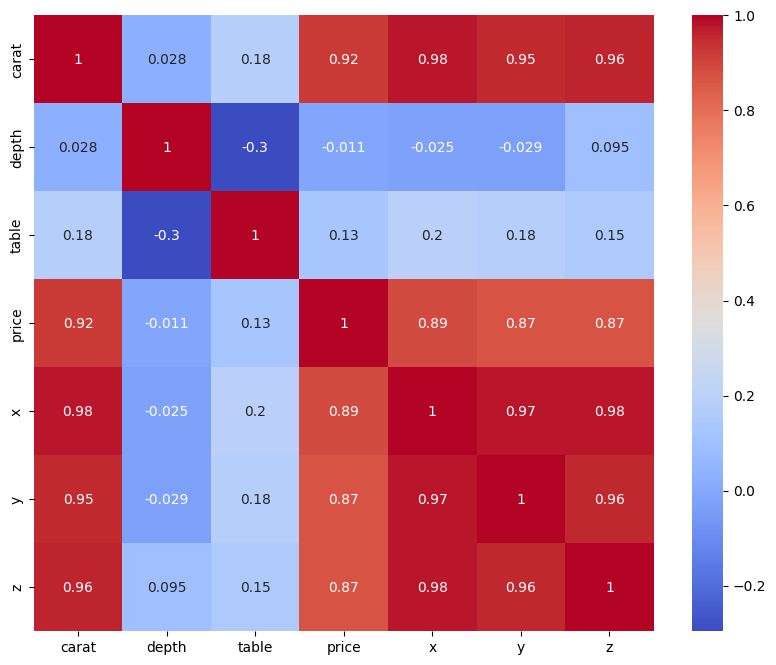

In [12]:
corr_matrix = data.corr(numeric_only=True)
plt.figure(figsize=(10,8))
sns.heatmap(corr_matrix, cmap="coolwarm", annot=True)
plt.show()

Наибольшую корреляцию с целевой переменной имеет признак `carat`. Чуть меньшую, но все же очень высокую корреляцию также имеют признаки размера бриллианта - `x`, `y` и `z`.

## Линейная регрессия

### Шаг 1

Оценим линейную регрессию на тренировочной выборке, посчитав среднеквадратичную ошибку:

In [13]:
model = LinearRegression()
model.fit(X_train, y_train)

y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

mse_train = mean_squared_error(y_train, y_train_pred)
mse_test = mean_squared_error(y_test, y_test_pred)

print(f"MSE на тренировочной выборке: {mse_train}")
print(f"MSE на тестовой выборке: {mse_test}")

MSE на тренировочной выборке: 1257429.2076311598
MSE на тестовой выборке: 1300843.8522870406


### Шаг 2

Отсортируем коэффициенты при признаках по модулю для оценки их важности:

In [14]:
for feature, coef in sorted(zip(X.columns, model.coef_), key=lambda x: abs(x[1]), reverse=True):
    print(f"{feature}: {coef}")

carat: 5489.778228172168
clarity_VS2: 1773.5410016604767
clarity_VS1: 1617.7405959398354
clarity_SI1: 1555.716316010489
clarity_VVS2: 1421.323428464845
x: -1275.1508240488936
clarity_VVS1: 1246.9783956089452
clarity_SI2: 1012.5550415230936
clarity_IF: 932.7014339568689
color_J: -523.5851802918269
color_I: -432.4624056802467
cut_Ideal: 405.1060935265571
color_H: -347.5103606896332
cut_Premium: 333.1515705671904
cut_Very Good: 298.9660483326022
color_G: -183.79048243534498
cut_Good: 167.6195924342019
depth: -97.33000833005576
color_F: -94.29275726534418
color_E: -74.88950998892128
z: -63.128212598735765
table: -57.0690485654195
y: 18.488358340738962


Мы видим что коэффицент при весе бриллианта (`carat`) на порядок превышает коэффиценты других вещественных признаков. Также большие по модулю коэффициенты у признаков прозрачности (`clarity`).

### Шаг 3

 Как можно заметить из анализа корреляционной матрицы (см. "Предобработка данных", Шаг 5), между некоторыми признаками имеется сильная корреляция, что может быть индикатором проблемы *мультиколлинеарности*. Ее проявление - большие по модулю коэффициенты и, как следствие, переобучение. Как известно, для решения этой проблемы можно либо исключить некоторые признаки из модели, либо использовать регуляризацию. Мы воспользуемся вторым вариантом.

Вспомним, что смысл регуляризации заключается в том, чтобы изменить функцию потерь так, чтобы модель старалась помимо функции потерь минимизировать и норму весов, тем самым устраняя проблемы, появляющиеся из-за мультиколлинеарности. При L1-регуляризации предлагается минимизировать следующую функцию потерь:

$$
\|y - X\hat{w}\|^2 + \alpha\sum_{i=1}^k|w_i|
$$

Такая модель называется Lasso-регрессией.

При L2-регуляризации предлагается минимизировать следующую функцию потерь:

$$
\|y - X\hat{w}\|^2 + \alpha\|w\|^2
$$

Такая модель называется Ridge-регрессией.

Обучим Lasso-регрессию и Ridge-регрессию, подобрав гиперпараметры регуляризации с помощью кросс-валидации:

In [15]:
lasso_cv = LassoCV(alphas=np.linspace(0, 10, 101), cv=5)
lasso_cv.fit(X_train, y_train)

print("Оптимальное значение alpha для Lasso:", lasso_cv.alpha_)

ridge_cv = RidgeCV(alphas=np.linspace(70, 80, 101), cv=5)
ridge_cv.fit(X_train, y_train)

print("Оптимальное значение alpha для Ridge:",  ridge_cv.alpha_)

Оптимальное значение alpha для Lasso: 3.2
Оптимальное значение alpha для Ridge: 78.1


In [16]:
lasso = Lasso(alpha=3.2)
lasso.fit(X_train, y_train)

lasso_mse_train = mean_squared_error(y_train, lasso.predict(X_train))
lasso_mse_test = mean_squared_error(y_test, lasso.predict(X_test))

ridge = Ridge(alpha=78.1)
ridge.fit(X_train, y_train)

ridge_mse_train = mean_squared_error(y_train, ridge.predict(X_train))
ridge_mse_test = mean_squared_error(y_test, ridge.predict(X_test))

print(f"Lasso Train MSE: {lasso_mse_train}, Test MSE: {lasso_mse_test}")
print(f"Ridge Train MSE: {ridge_mse_train}, Test MSE: {ridge_mse_test}")

Lasso Train MSE: 1263556.8233864377, Test MSE: 1308207.7380907703
Ridge Train MSE: 1264404.6362982006, Test MSE: 1306779.62260531


MSE в обоих случаях стала чуть больше, чем была изначально. Это значит что проблема мультиколлениарности в нашем случае не проявилась, скорее наоборот - регуляризация уменьшает веса при важных признаках, тем самым увеличивая ошибку.

In [17]:
print("Коэффициенты Lasso-регрессии:")
for feature, coef in sorted(zip(X.columns, lasso.coef_), key=lambda x: abs(x[1]), reverse=True):
    print(f"{feature}: {coef}")

Коэффициенты Lasso-регрессии:
carat: 5309.038617185497
clarity_VS2: 1555.274461784311
clarity_VS1: 1429.9480615805137
clarity_SI1: 1332.4014464110858
clarity_VVS2: 1269.4946204434355
clarity_VVS1: 1114.8404220781815
x: -1091.6325384538322
clarity_IF: 838.0753428487285
clarity_SI2: 818.1880766598338
color_J: -504.306288304183
color_I: -409.10235411494267
cut_Ideal: 341.8328332057553
color_H: -324.2566758438103
cut_Premium: 275.44686880254346
cut_Very Good: 246.68432385890583
color_G: -159.32124796975847
cut_Good: 129.14247299892065
depth: -98.78588415053324
color_F: -73.31360940051033
z: -61.80716453053244
table: -60.391716599164184
color_E: -52.45894477445604
y: -0.0


In [18]:
print("Коэффициенты Ridge-регрессии:")
for feature, coef in sorted(zip(X.columns, ridge.coef_), key=lambda x: abs(x[1]), reverse=True):
    print(f"{feature}: {coef}")

Коэффициенты Ridge-регрессии:
carat: 5158.999013834577
clarity_VS2: 1579.349295181278
clarity_VS1: 1451.6789214939454
clarity_SI1: 1355.252168873104
clarity_VVS2: 1289.095846559857
clarity_VVS1: 1133.7923169934998
x: -913.3792297893281
clarity_IF: 852.8277727355867
clarity_SI2: 841.5796599506428
color_J: -513.2101386025195
color_I: -422.21605475465276
cut_Ideal: 411.9611493712095
color_H: -340.51023345426864
cut_Premium: 339.0679764666726
cut_Very Good: 307.4984536307998
color_G: -180.12288152857673
cut_Good: 170.77092041519626
color_F: -93.35440106785038
z: -88.65362912707955
depth: -82.089249892747
color_E: -71.66086218977743
table: -58.14110797795797
y: -1.8513145451833677


В обоих случаях веса стали ниже по модулю чем были изначально, в том числе и у важных признаков.

### Шаг 4

Проблема мультиколлениарности в нашем случае не проявилась, однако мы можем проверить эффективность регуляризации, в случае если бы эта проблема была. Для этого, ради эксперимента, мы уберем параметр `drop_first = True` при кодировании категориальных признаков и обучим модель снова. Такие модели будем отмечать индексом 2.

In [19]:
data_encoded_2 = pd.get_dummies(data)

X_2 = data_encoded_2.drop(columns=["price"])
y_2 = data_encoded_2["price"]

X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(X_2, y_2, test_size=0.3, random_state=52)

scaler_2 = StandardScaler()
X_train_2 = scaler_2.fit_transform(X_train_2)
X_test_2 = scaler_2.transform(X_test_2)

In [20]:
model_2 = LinearRegression()
model_2.fit(X_train_2, y_train_2)

mse_train_2 = mean_squared_error(y_train_2, model_2.predict(X_train_2))
mse_test_2 = mean_squared_error(y_test_2, model_2.predict(X_test_2))

print(f"MSE 2 на тренировочной выборке: {mse_train_2}")
print(f"MSE 2 на тестовой выборке: {mse_test_2}")
print()

for feature, coef in sorted(zip(X_2.columns, model_2.coef_), key=lambda x: abs(x[1]), reverse=True):
    print(f"{feature}: {coef}")

MSE 2 на тренировочной выборке: 1274231.1890982282
MSE 2 на тестовой выборке: 1317678.8045753853

color_G: -7019384929534381.0
color_E: -6619713458952852.0
color_F: -6574535008070324.0
color_H: -6193245726850104.0
color_D: -5713141934695482.0
color_I: -5204897454987451.0
color_J: -3834463773865435.0
clarity_SI1: 493428884304520.75
cut_Ideal: -492512422896922.06
clarity_VS2: 482707475534573.1
cut_Premium: -438397149765598.4
clarity_SI2: 434290250134399.4
cut_Very Good: -420469503937257.06
clarity_VS1: 410346341881714.7
clarity_VVS2: 334111627962294.1
clarity_VVS1: 290358392389241.56
cut_Good: -289246428756552.9
clarity_IF: 204609051963650.6
cut_Fair: -172693424374641.22
clarity_I1: 137059348391306.16
carat: 5489.7869731566225
x: -1279.7441468690045
depth: -86.38004979385596
table: -80.32816856287869
z: -47.00120122833731
y: 3.7792431500906094


Мы видим, что веса, без `drop_first = True` и регуляризации, становятся очень большими по модулю, особенно если рассматривать категориальные признаки. Это происходит из-за линейной зависимости при OHE кодировании - если не убирать один столбец, сумма значений столбцов одного категориального признака равна единице (поскольку у нас среди них только один True и все остальные False). Это в свою очередь значит, что все комбинации весов, сумма которых одинакова, будут давать одинаковые прогнозы. При этом таких комбинаций бесконечно много, а потому обучение становится нестабильным, модель теряет свою обобщающую способность, а веса - интерпретируемость.

Посмотрим, что будет после регуляризации:

In [21]:
lasso_cv_2 = LassoCV(alphas=np.linspace(0, 10, 101), cv=5)
lasso_cv_2.fit(X_train_2, y_train_2)

print("Оптимальное значение alpha для Lasso 2:", lasso_cv_2.alpha_)

ridge_cv_2 = RidgeCV(alphas=np.linspace(90, 100, 101), cv=5)
ridge_cv_2.fit(X_train_2, y_train_2)

print("Оптимальное значение alpha для Ridge 2:",  ridge_cv_2.alpha_)

Оптимальное значение alpha для Lasso 2: 5.6000000000000005
Оптимальное значение alpha для Ridge 2: 98.9


In [22]:
lasso_2 = Lasso(alpha=5.6)
lasso_2.fit(X_train_2, y_train_2)
lasso_mse_train_2 = mean_squared_error(y_train_2, lasso_2.predict(X_train_2))
lasso_mse_test_2 = mean_squared_error(y_test_2, lasso_2.predict(X_test_2))

ridge_2 = Ridge(alpha=98.9)
ridge_2.fit(X_train_2, y_train_2)
ridge_mse_train_2 = mean_squared_error(y_train_2, ridge_2.predict(X_train_2))
ridge_mse_test_2 = mean_squared_error(y_test_2, ridge_2.predict(X_test_2))

print(f"Lasso Train MSE 2: {lasso_mse_train_2}, Lasso Test MSE 2: {lasso_mse_test_2}")
print(f"Ridge Train MSE 2: {ridge_mse_train_2}, Ridge Test MSE 2: {ridge_mse_test_2}")

Lasso Train MSE 2: 1261426.9280454542, Lasso Test MSE 2: 1303676.8855573067
Ridge Train MSE 2: 1263669.64617379, Ridge Test MSE 2: 1304045.7860009812


При применении регуляризации значения MSE возвращаются к тем, что были у нас изначально.

### Шаг 5

Несмотря на то, что ошибка в нашем случае при Lasso-регрессии становится больше, она обладает полезным свойством: ее можно использовать для отбора наиболее информативных признаков. Обучим Lasso- и Ridge-регрессии при различных значениях параметра регуляризации и построим график изменения евклидовой нормы весов в зависимости от них.

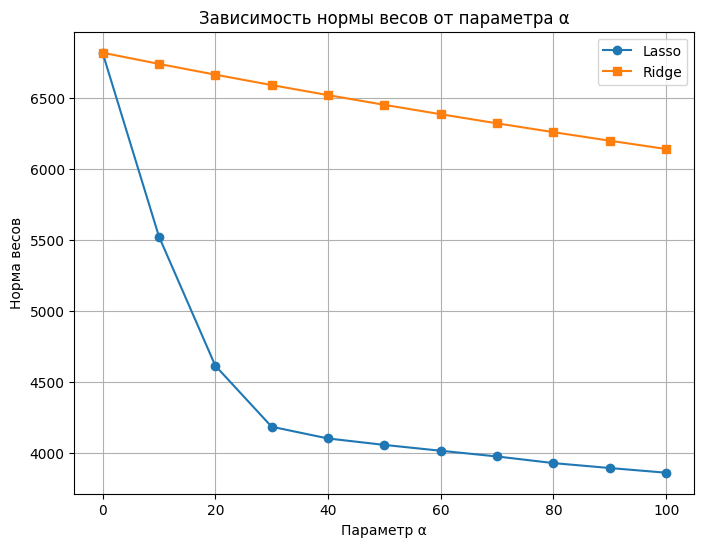

In [23]:
alphas = np.linspace(0, 100, 11)

lasso_norms = []
ridge_norms = []

for a in alphas:
    lasso = Lasso(alpha=a)
    lasso.fit(X_train, y_train)
    lasso_norm = np.linalg.norm(lasso.coef_)
    lasso_norms.append(lasso_norm)
    
    ridge = Ridge(alpha=a)
    ridge.fit(X_train, y_train)
    ridge_norm = np.linalg.norm(ridge.coef_)
    ridge_norms.append(ridge_norm)

plt.figure(figsize=(8, 6))
plt.plot(alphas, lasso_norms, marker='o', label='Lasso')
plt.plot(alphas, ridge_norms, marker='s', label='Ridge')
plt.xlabel('Параметр α')
plt.ylabel('Норма весов')
plt.title('Зависимость нормы весов от параметра α')
plt.legend()
plt.grid(True)
plt.show()


Как мы видим, при Lasso-регрессии норма весов снижается гораздо сильнее. Это происходит за счет того что Lasso чаще зануляет веса при наименее значимых признаках, тем самым и проводя их отбор. Зануление происходит из-за того что минимизация ошибки в Lasso-регрессии математически эквивалентна задаче:
$$
\left\{
\begin{array}{l}
\frac{1}{l}\sum_{i=1}^{l} \left( y_i - \langle w, x_i \rangle \right)^2 \longrightarrow \min \\[1ex]
\|w\|_1 <= c.
\end{array}
\right.
$$
Если смотреть на эту систему графически (где по осям расположена какая-то пара весов из модели), то мы пытаемся найти точку минимума внутри некого ромбика, центр которого расположен в начале координат. Если минимум располагается вне этого ромбика, то мы будем искать точку касания линии уровня с этим ромбиком. И эти точки касания с большой вероятностью будут касаться именно уголков ромба, т.е. точек где один из весов равен нулю (в отличии от Ridge-регрессии, где вместо ромбика окружность, и вероятность коснуться ее на оси гораздо меньше).

Картинка из [учебника Яндекса](https://education.yandex.ru/handbook/ml/article/linear-models?disableGlobalInfoCollect=false) для наглядности:

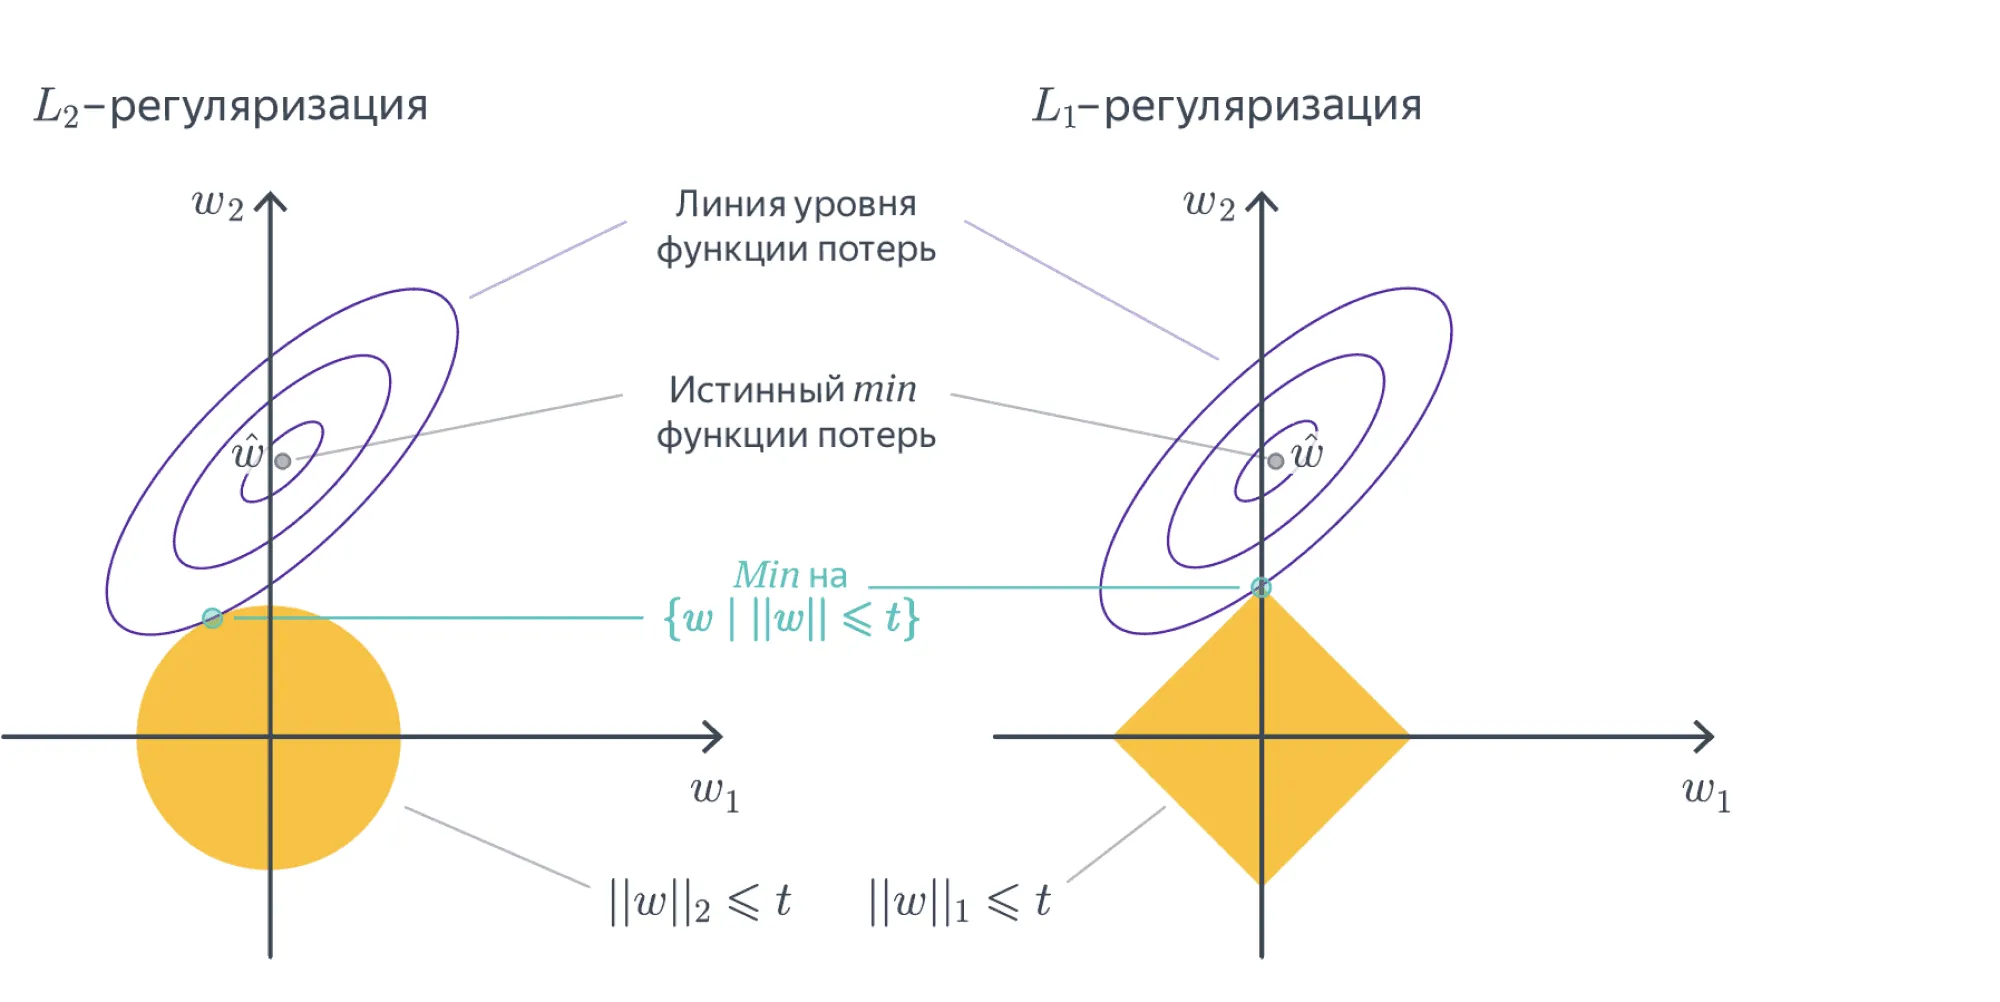



In [24]:
print("Коэффициенты Lasso-регрессии")
for feature, coef in sorted(zip(X.columns, lasso.coef_), key=lambda x: abs(x[1]), reverse=True):
    print(f"{feature}: {coef}")

Коэффициенты Lasso-регрессии
carat: 3823.2710182070477
clarity_SI2: -385.8836412171307
color_J: -270.98467386241185
color_I: -152.41858408377772
clarity_VVS2: 133.73096965211994
clarity_SI1: -127.34974887688855
clarity_VVS1: 101.2438716022534
clarity_IF: 90.20228354300752
color_H: -89.30468797232659
clarity_VS1: 44.51873296129804
cut_Ideal: 40.30422015171899
depth: -28.321552723460112
table: -0.0
x: 0.0
y: 0.0
z: 0.0
cut_Good: -0.0
cut_Premium: 0.0
cut_Very Good: 0.0
color_E: 0.0
color_F: 0.0
color_G: 0.0
clarity_VS2: 0.0


Посмотрев на коэффициенты Lasso-регрессии, мы можем заметить, что занулились веса у многих признаков. Это полезное свойство, поскольку данные признаки никак не участвуют при предсказании целевой переменной, а значит можно сократить выборку (в нашем случае почти вдвое), при этом не сильно увеличив ошибку (1300843 vs 1308207, прирост меньше 1%). При меньшем числе признаков модель быстрее обучается и прогнозирует (что важно при больших данных), выборка занимает меньше памяти, а интерпретируемость модели повышается.